# VALUE vs GROWTH DETECTION

This notebook contains all the code that will produce a model/signal to predict the optimum shift between value or growth investing.

_IMPORTS_

In [225]:
import os
import json
import pickle
import dotenv
from datetime import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### _LOAD DATA_

In [226]:
root_dir = os.path.dirname(os.getcwd())
DATA_DIR = os.path.join(root_dir, "data")
dotenv_file = os.path.join(root_dir, '.env')

#loading all etfs data
etfs_dict = {}
for f in os.listdir(os.path.join(DATA_DIR, "etf_data")):
    if f.startswith("SPY"):
        etfs_dict[f.strip(".csv")] = pd.read_csv(os.path.join(DATA_DIR, "etf_data", f))

with open (os.path.join(DATA_DIR, "etf_data", "us_etfs_list.pkl"), "rb") as f:
    etfs_list : dict = pickle.load(f)

#Load Commodities Futures Prices: .csv
commodities_dict = {}
commodities_files = os.listdir(os.path.join(DATA_DIR, "commodities"))
for f in commodities_files:
    commodities_dict[f.strip(".csv")] = pd.read_csv(os.path.join(DATA_DIR, "commodities", f))

#Load Currencies Prices: .csv
currencies_dict = {}
currencies_files = os.listdir(os.path.join(DATA_DIR, "currencies"))
for f in currencies_files:
    currencies_dict[f.strip(".csv")] = pd.read_csv(os.path.join(DATA_DIR, "currencies", f))

#FEDFUNDS and BALANCE: .pkl
macro_files = os.listdir(os.path.join(DATA_DIR, "macro_data"))
with open(os.path.join(DATA_DIR, "macro_data", "macro_data.pkl"), "rb") as f:
    macro_dict = pickle.load(f)


### EDA & Feature Eng

_Create Dataframes_

In [227]:
start, end = "2014-05-01", "2024-05-01"
daterange = pd.date_range(start=start, end=end, freq="d").strftime("%Y-%m-%d")
period = 30

etfs = [i[:-4] for i in os.listdir(os.path.join(DATA_DIR, "etf_data")) if i.startswith("SPY")]
etfs_df = pd.concat(
    [pd.read_csv(os.path.join(DATA_DIR, "etf_data",f"{i}.csv"),index_col="Date") for i in etfs],
    axis=1,
)
etfs_df.columns = etfs
etfs_df = np.log(etfs_df / etfs_df.shift(period))
etfs_df = etfs_df[(etfs_df.index >= start) & (etfs_df.index <= end)]
#-------------------------------------------------------------------------------------------------------------
currencies = [i[:-4] for i in os.listdir(os.path.join(DATA_DIR, "currencies"))]
curr_df = pd.concat(
    [pd.read_csv(os.path.join(DATA_DIR, "currencies",f"{i}.csv"), index_col="Date") for i in currencies],
    axis=1,
)
curr_df.columns = currencies
curr_df = np.log(curr_df/curr_df.shift(period))
curr_df = curr_df[(curr_df.index >= start) & (curr_df.index <= end)]
# #-------------------------------------------------------------------------------------------------------------
macro_ind = [i[:-4] for i in os.listdir(os.path.join(DATA_DIR, "macro_data")) if i.endswith(".csv")]
macro_df = pd.read_csv(os.path.join(DATA_DIR,"macro_data", "FEDFUNDS.csv"),index_col="Date")
macro_df = np.log(macro_df/macro_df.shift(1))
macro_df.columns = macro_ind
# #-------------------------------------------------------------------------------------------------------------
comm = [i[:-4] for i in os.listdir(os.path.join(DATA_DIR, "commodities")) if i.endswith(".csv")]
commodities_df = pd.concat(
    [pd.read_csv(os.path.join(DATA_DIR, "commodities", f"{i}.csv"),index_col="Date")["Close"] for i in comm],
    axis=1,
)
commodities_df = np.log(commodities_df/commodities_df.shift(period))
commodities_df = commodities_df[(commodities_df.index >= start) & (commodities_df.index <= end)]
commodities_df.columns = comm
# #-------------------------------------------------------------------------------------------------------------
#Set common indexes
all_data = pd.DataFrame(index=daterange)
all_data = all_data.merge(etfs_df, left_index=True, right_index=True, how="left")
all_data = all_data.merge(commodities_df, left_index=True, right_index=True, how="left")
all_data = all_data.merge(curr_df, left_index=True, right_index=True, how="left")
all_data = all_data.merge(macro_df, left_index=True, right_index=True, how="left")
all_data.index.name = "Date"
all_data.fillna(method="ffill", inplace=True)

all_data["midpoint"] = (all_data["SPYG"] + all_data["SPYV"]) / 2


_Visualize Data_

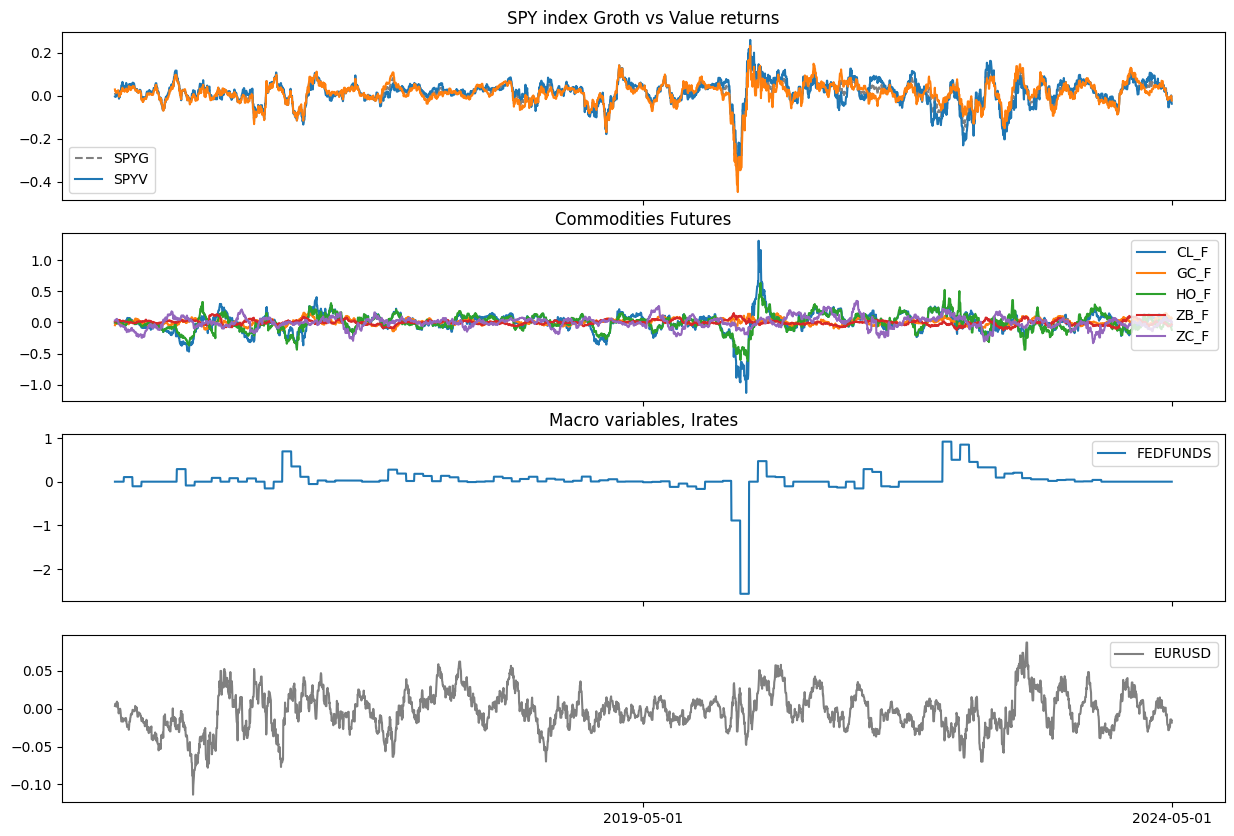

In [228]:
fig, axs = plt.subplots(nrows=4, figsize=(15, 10), sharex=True)

#ETFs
SPYG = all_data.SPYG
SPYV = all_data.SPYV
SPY_midpoint = (SPYG + SPYV) / 2
axs[0].plot(SPY_midpoint, color="grey", linestyle="dashed")
axs[0].plot(all_data["SPYG"])
axs[0].plot(all_data["SPYV"])
axs[0].legend(["SPYG", "SPYV"])
axs[0].set_title("SPY index Groth vs Value returns")

#Commodities
for i in comm:
    axs[1].plot(all_data[i])
axs[1].legend(comm)
axs[1].set_title("Commodities Futures")

#Macro
axs[2].plot(all_data["FEDFUNDS"])
axs[2].legend(macro_df.columns)
axs[2].set_title("Macro variables, Irates")

#currencies
axs[3].plot(all_data["EURUSD"], color="grey")
axs[3].legend(curr_df.columns);

plt.xticks(ticks=all_data.index[::-int(len(all_data)/2)])
plt.savefig(os.path.join(root_dir,"charts", "all_features_history.png"))

#### _Statistical Measures_

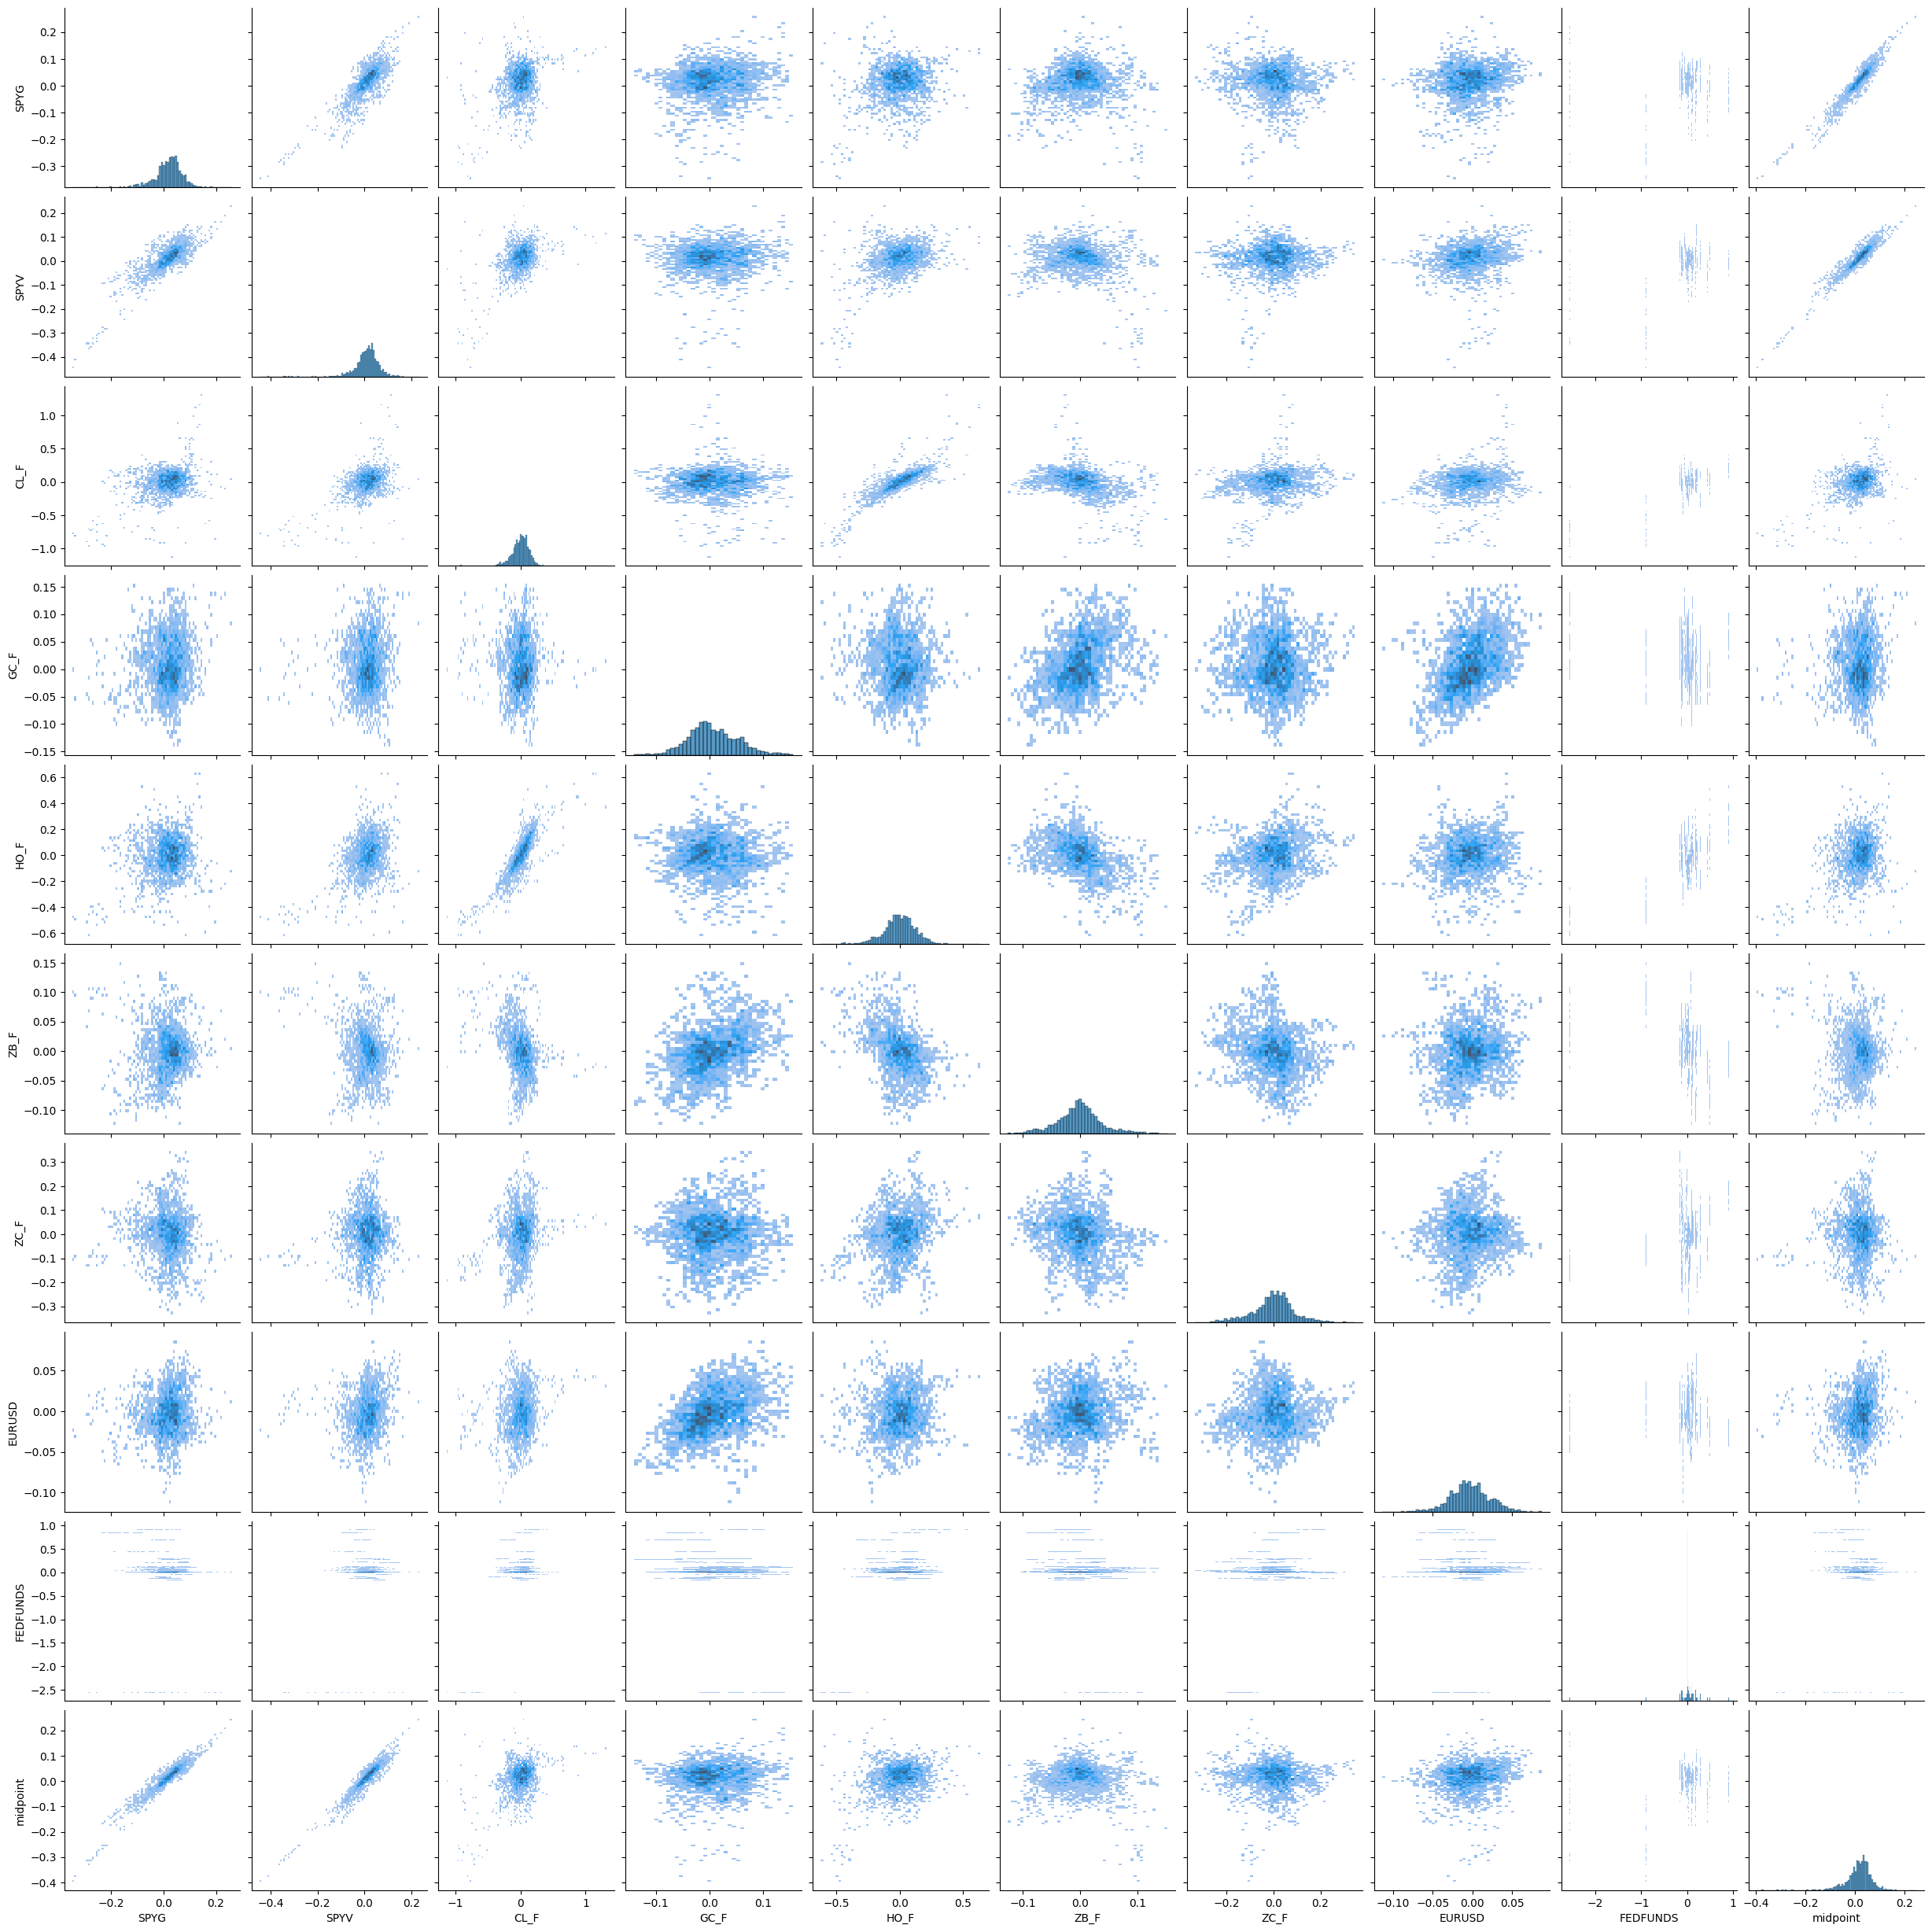

In [229]:
sns.pairplot(all_data, kind="hist")

_Correlation_

<Axes: >

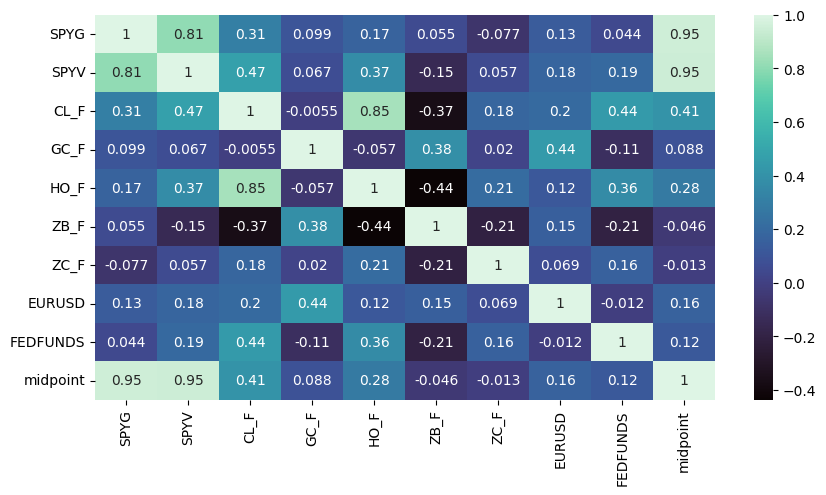

In [230]:
fig = plt.figure(figsize=(10, 5))
sns.heatmap(all_data.corr(method="pearson"),cmap="mako",annot=True)

### _Time Series Analysis_

_Autocorrelation_

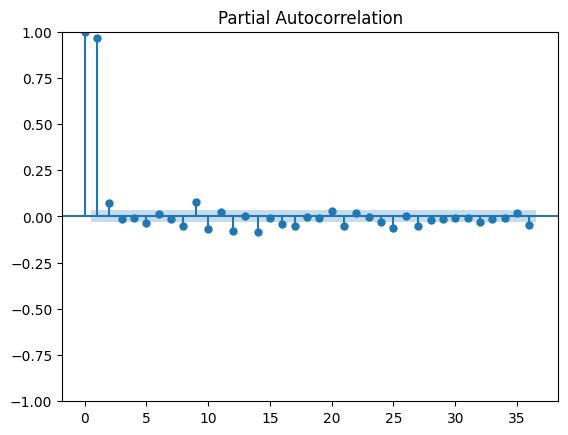

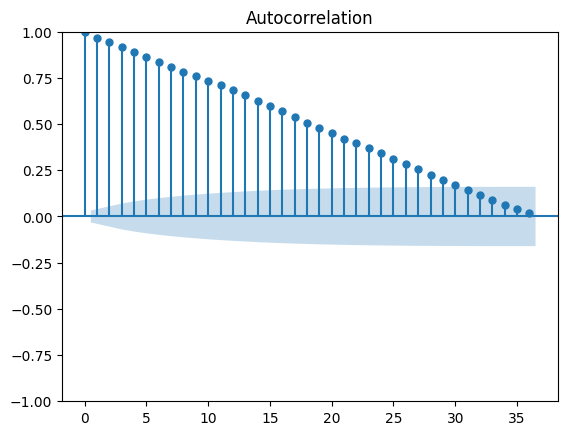

In [244]:
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


plot_pacf(all_data["SPYG"].values);
plot_acf(all_data["SPYG"].values);

### _Clasification of Growth/Value Moments_

In [231]:
# seperate both investing styles using the midpoint:
# 1 for growth 0 for value
window = -30
all_data["moment"] = (SPYG > SPY_midpoint).astype(int)
all_data["moment"].shift(window)
all_data.dropna(inplace=True)
y = all_data["moment"]
not_features = ["SPYG", "SPYV", "moment", "midpoint"]
features = [i for i in all_data.columns if i not in not_features]
X = all_data[features]

In [232]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from scipy.spatial import distance

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

_Standard NNeighbor Model_

In [233]:
knn = KNeighborsClassifier(algorithm="auto")
cv = GridSearchCV(estimator=knn, param_grid={'n_neighbors': range(1, 60)})
cv.fit(X_train, y_train)
predictions = cv.predict(X_test)

In [234]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.75      0.33      0.45       463
           1       0.56      0.89      0.69       451

    accuracy                           0.60       914
   macro avg       0.66      0.61      0.57       914
weighted avg       0.66      0.60      0.57       914



_Ensemble RF Model_

In [235]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(criterion="gini",random_state=42)
forest.fit(X_train, y_train)
predictions = forest.predict(X_test)

In [236]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.63      0.50      0.56       463
           1       0.57      0.69      0.63       451

    accuracy                           0.60       914
   macro avg       0.60      0.60      0.59       914
weighted avg       0.60      0.60      0.59       914



_Ensemble AdaBoost_

In [237]:
from sklearn.ensemble import AdaBoostClassifier

classifier = AdaBoostClassifier(n_estimators=100, random_state=42)
classifier.fit(X_test, y_test)
predictions = classifier.predict(X_test)

In [238]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       463
           1       0.94      0.95      0.94       451

    accuracy                           0.94       914
   macro avg       0.94      0.94      0.94       914
weighted avg       0.94      0.94      0.94       914



_Testing Predictions_

In [239]:
# Calculate cumulative returns for independent assets
from tabulate import tabulate

SPYG_cret = SPYG[y_test.index].cumsum()
SPYV_cret = SPYV[y_test.index].cumsum()
STRAT_cret = []
for i in range(len(SPYG_cret)):
    if predictions[i] == 1:
        STRAT_cret.append(SPYG[y_test.index][i])
    if predictions[i] == 0: 
        STRAT_cret.append(SPYV[y_test.index][i])

STRAT_cret = np.cumsum(STRAT_cret)
results = [
    ["SPYV ETF only", f"{format(SPYV_cret.values[-1],'.2f')}%"], 
    ["SPYG ETF only", f"{format(SPYG_cret.values[-1],'.2f')}%"],
    ["Value/Growth Momment Classification Strategy", f"{format(STRAT_cret[-1],'.2f')}%"]
]

headers = ["Strategies","cumulative returns"]


with open(os.path.join(root_dir, "Research", "SPY_Testing.txt"),'w+') as f:
    print(tabulate(results, headers, tablefmt="github"), file=f)

_visualize results_

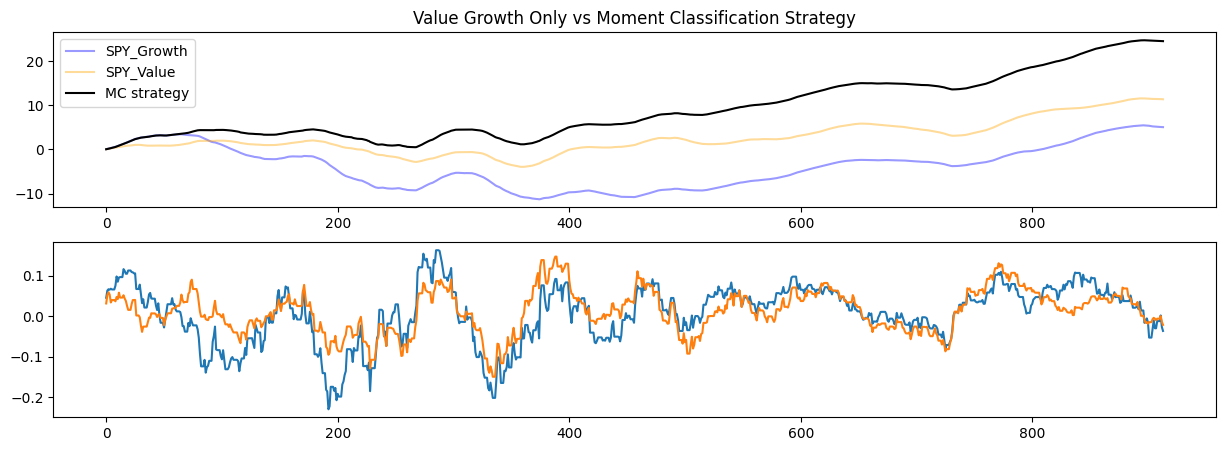

In [246]:
fig, ax = plt.subplots(nrows=2, figsize=(15,5))

ax[0].plot(SPYG_cret.values, color="blue", alpha=0.4)
ax[0].plot(SPYV_cret.values, color="orange", alpha=0.4)
ax[0].plot(STRAT_cret, color="black")
tittle = "Value Growth Only vs Moment Classification Strategy"
ax[0].set_title(tittle)
ax[0].legend(["SPY_Growth", "SPY_Value", "MC strategy"])
ax[1].plot(SPYG[y_test.index].values)
ax[1].plot(SPYV[y_test.index].values)
plt.savefig(os.path.join(root_dir, "charts", f"{tittle.replace(" ", "_")}.png"))

### Backtesting

_Backtesting with Long/Short Value etf in Europe_

| Strategies      | returns   |
|-----------------|-----------|
| Asset ROI       | 40.40%    |
| Strategy Returs | 103.89%   |


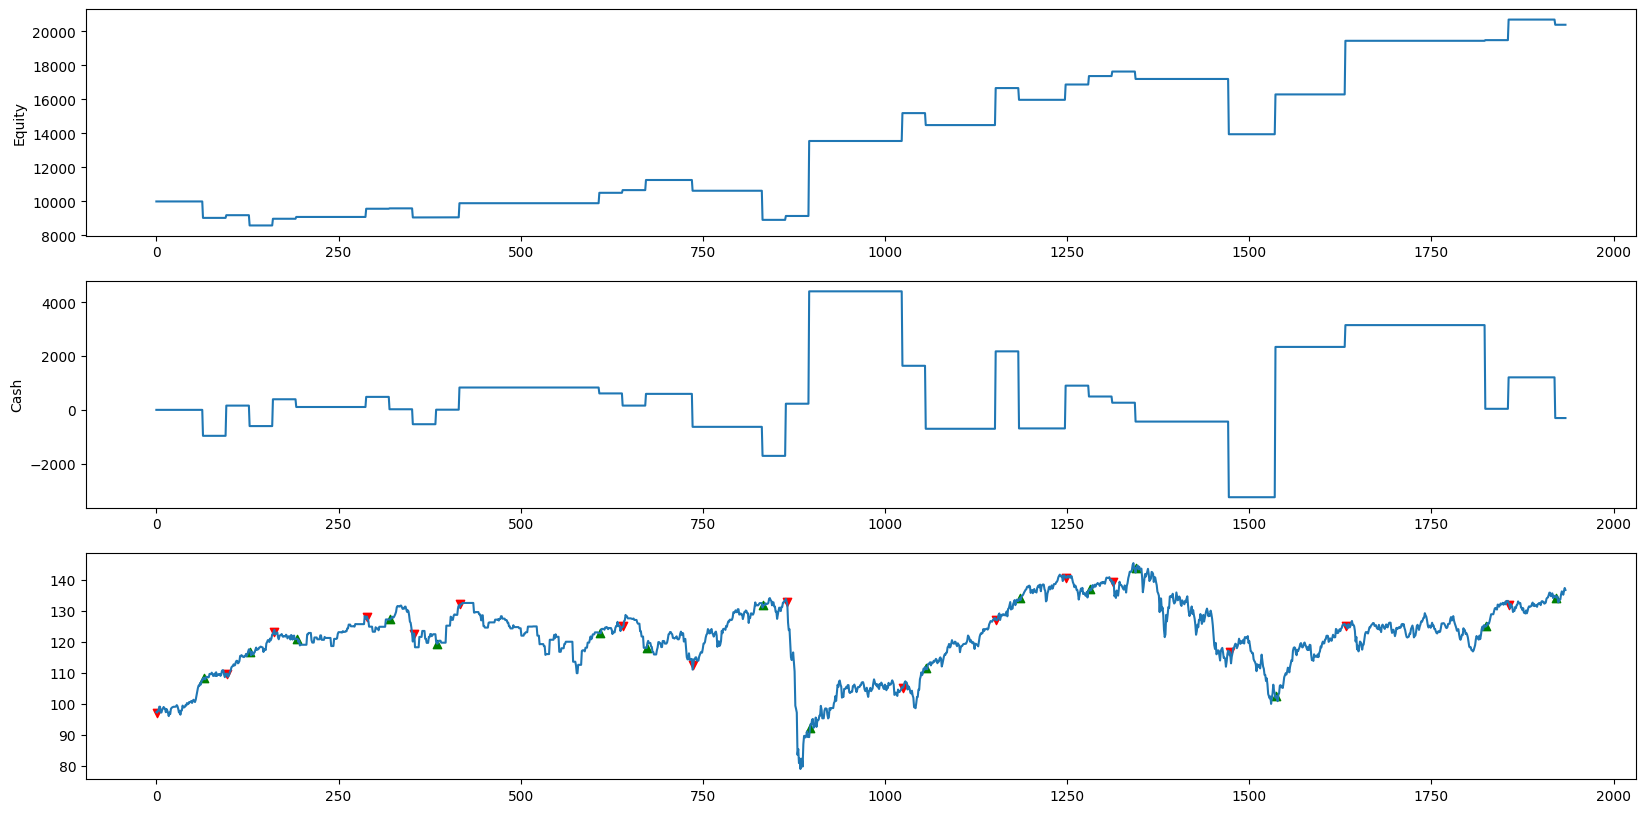

In [241]:
valu_etf = pd.read_csv(os.path.join(DATA_DIR, "etf_data", "VALU.DE.csv")).set_index("Date")
valu_etf["returns"] = np.log(valu_etf["Close"]/valu_etf["Close"].shift(1)) #period = 5
valu_etf.dropna(inplace=True)

X_eu = X[X.index.isin(valu_etf.index)]
europe_predictions = classifier.predict(X_eu)
X_eu["predictions"] = europe_predictions
valu_etf = valu_etf[valu_etf.index.isin(X_eu.index)]
#making predictions:

buy_idx = np.where(europe_predictions == 0)
sell_idx = np.where(europe_predictions == 1)

class my_backtester:
    
    def __init__(self) -> None:
        pass

    def run(self, cash, data, buy_and_hold_days, print_results:bool=0):
        if data is None or data.empty:
            return None, None
        self.buy_and_hold_days = buy_and_hold_days
        self.equity = cash
        self.cash = cash
        self.data = data
        self.n = len(data)
        self.last_entry = 0
        self.current_signal = None
        self.position = {"short": 0, "long": 0}
        self.history = {"equity":[], "cash": [], "entries":[]}
        i = 0
        while i < self.n:
            self.current_signal = self.data.predictions[i]
            Q = 1 * self.equity
            if self.current_signal == 1 and self.position["short"] == 0 and i % self.buy_and_hold_days == 0:
                if self.position["long"] != 0:
                    value = ((self.data.Close[i] - self.last_entry) / self.last_entry) \
                        * (self.position["long"] * self.last_entry)
                    self.equity += value
                    self.cash = self.equity
                    self.position["long"] = 0
                self.position["short"] = int((Q) / self.data.Close[i])
                self.last_entry = self.data.Close[i]
                self.cash -= Q
                i+=1
                self.history["entries"].append((self.current_signal, i))
                self.history["equity"].append(self.equity)
                self.history["cash"].append(self.cash)
                continue
            if self.current_signal == 0 and self.position["long"] == 0 and i % self.buy_and_hold_days == 0:
                if self.position["short"] != 0:
                    value = ((self.last_entry - self.data.Close[i]) / self.data.Close[i]) \
                        * (self.position["short"] * self.last_entry)
                    self.equity += value
                    self.cash = self.equity
                    self.position["short"] = 0
                self.position["long"] = int((Q) / self.data.Close[i])
                self.last_entry = self.data.Close[i]
                self.cash -= Q
                i+=1
                self.history["entries"].append((self.current_signal,i))
                self.history["equity"].append(self.equity)
                self.history["cash"].append(self.cash)
                continue
            else:
                self.history["equity"].append(self.equity)
                self.history["cash"].append(self.cash)
                i+=1

        returns = (((self.history["equity"][-1] - self.history["equity"][0]) / self.history["equity"][0])*100)
        asset_returns = ((self.data["Close"][-1] - self.data["Close"][0]) / self.data["Close"][0])*100
        results = [
            ["Asset ROI", f"{format(asset_returns,'.2f')}%"],
            ["Strategy Returs", f"{format(returns,'.2f')}%"],
        ]
        headers = ["Strategies","returns"]
        if print_results:
            print(tabulate(results, headers, tablefmt="github"))
        return returns, asset_returns
        
    def visualize(self):
        fig, ax = plt.subplots(nrows=3, figsize=(20, 10))
        ax[0].plot(self.history["equity"])
        ax[0].set_ylabel("Equity")
        ax[1].plot(self.history["cash"])
        ax[1].set_ylabel("Cash")
        ax[2].plot(self.data.Close.values)
        entries_buy = [i[1] for i in self.history["entries"] if i[0] == 0]
        entries_sell = [i[1] for i in self.history["entries"] if i[0] == 1]
        ax[2].scatter(entries_sell, self.data["Close"][entries_sell],color="red", marker="v")
        ax[2].scatter(entries_buy, self.data["Close"][entries_buy],color="green", marker="^")
        
data = pd.concat(
    [
        valu_etf,
        X_eu["predictions"]
    ],
    axis=1, 
)
data.index = pd.DatetimeIndex(data.index)

backtester = my_backtester()
returns = backtester.run(cash=10000, data=data, buy_and_hold_days= 32,print_results=1)
backtester.visualize()

_Backtesting for many european ETFs_

In [224]:
def make_predictions(ticker, X) -> pd.DataFrame:    
        etf = pd.read_csv(os.path.join(DATA_DIR, "testing_data", f"{ticker}.csv")).set_index("Date")
        etf["returns"] = np.log(etf["Close"]/etf["Close"].shift(1)) #period = 5
        etf.dropna(inplace=True)
        X_eu = X[X.index.isin(etf.index)]
        if len(X_eu) == 0:
             return
        europe_predictions = classifier.predict(X_eu)
        X_eu["predictions"] = europe_predictions
        etf = etf[etf.index.isin(X_eu.index)]
        data = pd.concat(
            [
                etf,
                X_eu["predictions"]
            ],
            axis=1, 
        )
        data.index = pd.DatetimeIndex(data.index)
        return data

with open(os.path.join(DATA_DIR, "testing_data", "testing_etfs_eu.pkl"),'rb') as f:
    testing_etfs = pickle.load(f)

results = []
performance = 0
for i, ticker in enumerate(testing_etfs):
    data = make_predictions(ticker, X=X)
    returns, asset_returns = backtester.run(cash=10000, data=data, buy_and_hold_days=32, print_results=0)
    if returns is None or asset_returns is None or asset_returns < -10 or returns > 150:
         continue
    performance += returns
    if returns and asset_returns:
        results.append(
                [
                    f"{ticker}", f"{format(asset_returns,'.2f')}%",
                    f"{format(returns,'.2f')}%"],
        )
    if i + 1 == len(testing_etfs):
        results.append(["performance : ", "", f"{format(performance,'.2f')}%"])
    else:
        continue

with open(os.path.join(root_dir, "Research", "Moment_Classification_Results.txt"),'w+') as f:
    print(tabulate(results, headers=["ETF Symbol","ROI", "Strategy Returns"], tablefmt="github"), file=f)